In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('/content/sample_data/waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


#Feature engineering

In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [6]:
# 1. Create `km_per_driving_day` feature, representing the mean number of kilometers driven on each driving day in the last month for each user.
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [7]:
# 1. Convert infinite values to zero
#df['km_per_driving_day'].replace([np.inf], 0, inplace=True)
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [8]:
# 1. Create `percent_sessions_in_last_month` feature that represents the percentage of each user's total sessions that were logged in their last month of use.
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 2. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [9]:
# Create `professional_driver` feature
#  binary feature professional_driver where 1 is for users who had 60 or more drives and drove on 15+ days in the last month.
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1


In [10]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713


In [11]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [12]:
# Create `km_per_hour` feature, representing the mean kilometers per hour driven in the last month.
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [13]:
# Create `km_per_drive` feature, representing the mean number of kilometers per drive made in the last month for each user.
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [14]:
# 1. Convert infinite values to zero
df['km_per_drive'].replace([np.inf], 0, inplace=True)

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [15]:
# Create `percent_of_sessions_to_favorite` feature  that represents the percentage of total sessions that were used to navigate to one of the users' favorite places
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] +
                                         df['total_navigations_fav2']) / (df['total_sessions'])


# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

##Drop missing values

In [16]:
# Drop rows with missing values
print(f"Number of missing values: {df.isna().any(axis=1).sum()}")

df = df.dropna(subset=['label'])
print(f"Number of missing values: {df.isna().any(axis=1).sum()}")

Number of missing values: 700
Number of missing values: 0



using EDA you can check outliers - many of these columns have outliers.
However, tree-based models are resilient to outliers, so there is no need to make any imputations.


##Variable encoding

In [17]:
# Create new `device2` variable, where Android is 0 and iPhone is 1
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']]

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0
...,...,...
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1


##Target encoding

In [18]:
# Create binary `label2` column
df['label2'] = np.where(df['label'] == 'churned', 1, 0)
df[['label', 'label2']]

,label,label2
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0
...,...,...
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1


##Feature selection

In [19]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)

##Evaluation metric

In [20]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely

##Modeling

In [21]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [22]:
for x in [X_tr, X_val, X_test]:
    print(len(x))

11439
2860
2860


#Random forest

In [23]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'n_estimators' : [50,100],
              'max_depth' : [None],
              'min_samples_leaf' : [0.5,1],
              'min_samples_split' : [0.001, 0.01],
              'max_features' : [1.0],
              'max_samples' : [.5,.9]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
%time
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [24]:
%time
rf_cv.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [0.5, 1],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [50, 100]},
             refit='recall', scoring={'precision', 'recall', 'accuracy', 'f1'})

In [25]:
# Examine best score
rf_cv.best_score_

0.13731665228645384

In [26]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 0.001,
 'n_estimators': 50}

In [27]:
def make_results(model_name:str, model_object, metric:str):

    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV


    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results['mean_test_recall'].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [28]:
rf_cv_results = make_results('Random Forest CV', rf_cv, scoring)
rf_cv_results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.458269,0.137317,0.210638,0.818161


#XGBoost

In [29]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params_xgb = {'max_depth': [8,12],
                 'min_child_weight': [1,3,5],
                 'learning_rate': [0.1, 0.2, 0.3],
                 'n_estimators': [300],
                 'subsample': [0.5],
                 'colsample_bytree': [0.5]
                }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
%time
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [30]:
%time
# fit the GridSearch model to training data

xgb_cv.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 28.6 µs


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features", "max_samples", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features", "max_samples", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features", "max_samples", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:30:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features", "max_samples", "min_samples_leaf", "min_samples_split" 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [0.5, 1],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [50, 100]},
             refit='recall', scoring={'precision', 'recall', 'accuracy', 'f1'})

In [31]:
# Examine best score
xgb_cv.best_score_

0.1740983606557377

In [32]:
# Examine best parameters
xgb_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.5,
 'min_samples_leaf': 0.5,
 'min_samples_split': 0.001,
 'n_estimators': 100}

In [33]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGBoost', xgb_cv, 'recall')
results = pd.concat([rf_cv_results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.458269,0.137317,0.210638,0.818161
0,XGBoost,0.407141,0.174098,0.242806,0.807904


##Model selection
Random forest

In [34]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [35]:
def get_test_scores(model_name:str, preds, y_test_data):

    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [36]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.458269,0.137317,0.210638,0.818161
0,XGBoost,0.407141,0.174098,0.242806,0.807904
0,RF val,0.443662,0.124260,0.194145,0.817133


XGBoost


In [37]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.458269,0.137317,0.210638,0.818161
0,XGBoost,0.407141,0.174098,0.242806,0.807904
0,RF val,0.443662,0.124260,0.194145,0.817133
0,XGB val,0.434579,0.183432,0.257975,0.812937


Use champion model to predict on test data

In [38]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.458269,0.137317,0.210638,0.818161
0,XGBoost,0.407141,0.174098,0.242806,0.807904
0,RF val,0.443662,0.124260,0.194145,0.817133
0,XGB val,0.434579,0.183432,0.257975,0.812937
0,XGB test,0.377593,0.179487,0.243316,0.802098


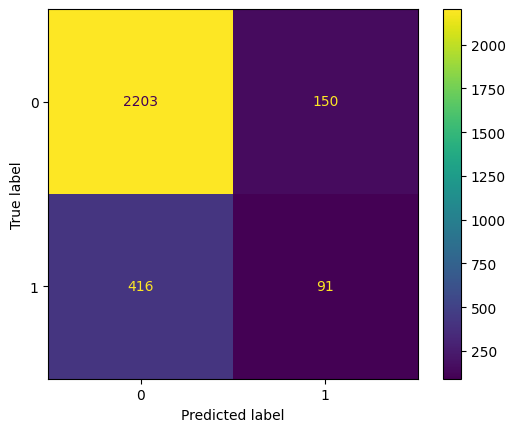

In [39]:
# Generate array of values for confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate).
    Returns a plot of confusion matrix for predictions on y data.
    '''

    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()


# Plot confusion matrix
conf_matrix_plot(xgb_cv, X_test, y_test)

##Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

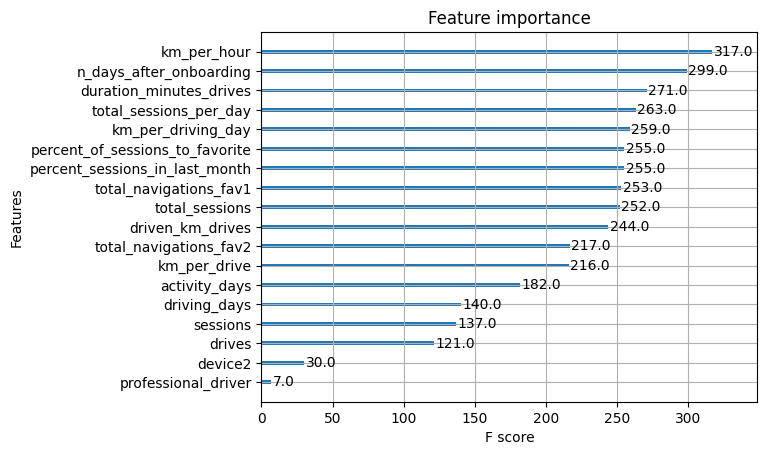

In [40]:
plot_importance(xgb_cv.best_estimator_)

##Identify an optimal decision threshold

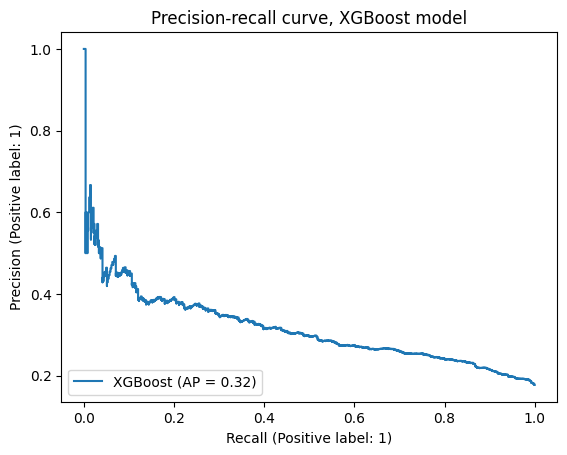

In [41]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

In [42]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.957772  , 0.04222796],
       [0.7727453 , 0.22725467],
       [0.9899129 , 0.01008707],
       ...,
       [0.4481951 , 0.5518049 ],
       [0.98297894, 0.01702103],
       [0.79894567, 0.2010543 ]], dtype=float32)

In [43]:
# Create a list of just the second column values (probability of target)
positive_class_scores = predicted_probabilities[:, 1]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in positive_class_scores])

new_preds

array([0, 0, 0, ..., 1, 0, 0])

In [44]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.372434,0.250493,0.299528,0.792308


In [45]:
# Compare these numbers with the results from earlier.
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.458269,0.137317,0.210638,0.818161
0,XGBoost,0.407141,0.174098,0.242806,0.807904
0,RF val,0.443662,0.124260,0.194145,0.817133
0,XGB val,0.434579,0.183432,0.257975,0.812937
0,XGB test,0.377593,0.179487,0.243316,0.802098


In [46]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall

In [47]:
# Get the predicted probabilities from the champion model
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, predicted_probabilities, 0.5)

(0.177, 0.5009861932938856)

In [48]:
# Create an array of new predictions that assigns a 1 to any value >= 0.18
new_preds = np.array([1 if x >= 0.18 else 0 for x in positive_class_scores])
new_preds

# Get evaluation metrics for when the threshold is 0.18
get_test_scores('XGB, threshold = 0.18', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.18",0.297998,0.499014,0.373156,0.702797
